In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

class FangTianXiaSpider:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
            'Referer': 'https://esf.fang.com/'
        })
        self.base_url = "https://sh.esf.fang.com/house/i3{}-t09-kw%D0%EC%BC%D2%BB%E3/"
        self.data = []
    
    def parse_property(self, dl_element):
        """解析单个房源信息"""
        property_info = {}
        
        try:
            # 提取标题
            title_elem = dl_element.find('span', class_='tit_shop')
            if title_elem:
                property_info['标题'] = title_elem.get_text(strip=True)
            
            # 提取基本信息
            tel_shop = dl_element.find('p', class_='tel_shop')
            if tel_shop:
                # 户型
                layout = tel_shop.get_text(strip=True).split('|')[0].strip()
                property_info['户型'] = layout
                
                # 面积
                area_match = re.search(r'(\d+\.?\d*)\s*㎡', tel_shop.get_text())
                if area_match:
                    property_info['面积(㎡)'] = float(area_match.group(1))
                
                # 楼层信息
                floor_elem = tel_shop.find('a', class_='link_rk')
                if floor_elem:
                    floor_text = floor_elem.get_text(strip=True)
                    total_floors_match = re.search(r'共(\d+)层', tel_shop.get_text())
                    if total_floors_match:
                        property_info['楼层'] = f"{floor_text}（共{total_floors_match.group(1)}层）"
                
                # 朝向
                orientation = None
                for part in tel_shop.get_text().split('|'):
                    if '向' in part:
                        orientation = part.strip()
                        break
                if orientation:
                    property_info['朝向'] = orientation
                
                # 建成年份
                year_match = re.search(r'(\d{4})年建', tel_shop.get_text())
                if year_match:
                    property_info['建成年份'] = int(year_match.group(1))
                
                # 经纪人
                agent_elem = tel_shop.find('span', class_='people_name')
                if agent_elem and agent_elem.find('a'):
                    property_info['经纪人'] = agent_elem.find('a').get_text(strip=True)
            
            # 提取小区和位置信息
            add_shop = dl_element.find('p', class_='add_shop')
            if add_shop:
                community = add_shop.find('a')
                if community:
                    property_info['小区'] = community.get_text(strip=True)
                
                location = add_shop.find('span')
                if location:
                    property_info['位置'] = location.get_text(strip=True)
            
            # 提取标签信息
            label = dl_element.find('p', class_='clearfix label')
            if label:
                tags = []
                # 提取满五/满二等标签
                for a in label.find_all('a'):
                    tags.append(a.get_text(strip=True))
                
                # 提取地铁信息
                subway = label.find('span', class_='icon_dt')
                if subway:
                    property_info['地铁'] = subway.get_text(strip=True)
                
                if tags:
                    property_info['标签'] = ', '.join(tags)
            
            # 提取价格信息
            price_right = dl_element.find('dd', class_='price_right')
            if price_right:
                # 总价
                total_price = price_right.find('span', class_='red')
                if total_price:
                    total_price_text = total_price.get_text(strip=True)
                    price_match = re.search(r'(\d+\.?\d*)\s*万', total_price_text)
                    if price_match:
                        property_info['总价(万元)'] = float(price_match.group(1))
                
                # 单价
                unit_price = price_right.find_all('span')[-1]
                if unit_price and '元/㎡' in unit_price.get_text():
                    unit_price_text = unit_price.get_text(strip=True)
                    unit_match = re.search(r'(\d+\.?\d*)\s*元/㎡', unit_price_text)
                    if unit_match:
                        property_info['单价(元/㎡)'] = float(unit_match.group(1))
            
            return property_info
        
        except Exception as e:
            print(f"解析房源信息时出错: {e}")
            return None
    
    def crawl_page(self, url):
        """爬取单个页面"""
        try:
            print(f"正在爬取: {url}")
            response = self.session.get(url)
            response.encoding = 'utf-8'
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # 找到房源列表容器
                shop_list = soup.find('div', class_='shop_list')
                if not shop_list:
                    shop_list = soup.find('div', class_='shop_list shop_list_4')
                
                if shop_list:
                    # 获取所有房源dl元素
                    property_dls = shop_list.find_all('dl', class_='clearfix')
                    properties = []
                    
                    for dl in property_dls:
                        # 跳过广告等非房源元素
                        if 'id' not in dl.attrs:
                            continue
                        
                        property_info = self.parse_property(dl)
                        if property_info:
                            properties.append(property_info)
                    
                    return properties
                else:
                    print("未找到房源列表容器")
                    return []
            else:
                print(f"请求失败，状态码: {response.status_code}")
                return []
        except Exception as e:
            print(f"爬取页面时出错: {e}")
            return []
    
    def crawl(self, pages=20):
        """爬取多页数据"""
        for page in range(1, pages + 1):
            if page == 1:
                url = self.base_url.format(1)
            else:
                url = self.base_url.format(page)
            
            properties = self.crawl_page(url)
            if properties:
                self.data.extend(properties)
                print(f"第{page}页获取到{len(properties)}条房源信息")
            else:
                print(f"第{page}页未获取到数据")
            
            # 添加延迟，避免请求过于频繁
            if page < pages:
                time.sleep(2)
        
        print(f"总共爬取{len(self.data)}条房源信息")
        self.save_to_excel()
    
    def save_to_excel(self, filename='徐家汇二手房数据.xlsx'):
        """保存数据到Excel文件"""
        if not self.data:
            print("没有数据可保存")
            return
        
        # 将数据转换为DataFrame
        df = pd.DataFrame(self.data)
        
        # 保存为Excel文件
        df.to_excel(filename, index=False, engine='openpyxl')
        print(f"数据已保存到 {filename}")

# 运行爬虫
if __name__ == "__main__":
    spider = FangTianXiaSpider()
    spider.crawl(pages=20)

正在爬取: https://sh.esf.fang.com/house/i31-t09-kw%D0%EC%BC%D2%BB%E3/
第1页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i32-t09-kw%D0%EC%BC%D2%BB%E3/
第2页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i33-t09-kw%D0%EC%BC%D2%BB%E3/
第3页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i34-t09-kw%D0%EC%BC%D2%BB%E3/
第4页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i35-t09-kw%D0%EC%BC%D2%BB%E3/
第5页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i36-t09-kw%D0%EC%BC%D2%BB%E3/
第6页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i37-t09-kw%D0%EC%BC%D2%BB%E3/
第7页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i38-t09-kw%D0%EC%BC%D2%BB%E3/
第8页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i39-t09-kw%D0%EC%BC%D2%BB%E3/
第9页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i310-t09-kw%D0%EC%BC%D2%BB%E3/
第10页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i311-t09-kw%D0%EC%BC%D2%BB%E3/
第11页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/house/i312-t09-kw%D0%EC%BC%D2%BB%E3/
第12页获取到60条房源信息
正在爬取: https://sh.esf.fang.com/hous

In [15]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

class FangTianXiaRentSpider:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
            'Referer': 'https://zu.fang.com/'
        })
        self.base_url = "https://sh.zu.fang.com/house/i3{}-s31-t01-kw%D0%EC%BC%D2%BB%E3/"
        self.data = []
    
    def parse_rental_property(self, dl_element):
        """解析单个租房房源信息"""
        property_info = {}
        
        try:
            # 提取标题
            title_elem = dl_element.find('p', class_='title')
            if title_elem:
                title_a = title_elem.find('a')
                if title_a:
                    property_info['标题'] = title_a.get_text(strip=True)
            
            # 提取租赁信息（整租/合租、户型、面积、朝向）
            info_elem = dl_element.find('p', class_='font15 mt12 bold')
            if info_elem:
                info_text = info_elem.get_text(strip=True)
                # 解析字符串，例如"整租|2室2厅|116㎡|朝东"
                info_parts = [part.strip() for part in info_text.split('|') if part.strip()]
                property_info['租赁方式'] = info_parts[0] if len(info_parts) > 0 else ""
                property_info['户型'] = info_parts[1] if len(info_parts) > 1 else ""
                
                # 提取面积
                if len(info_parts) > 2:
                    area_match = re.search(r'(\d+\.?\d*)\s*㎡', info_parts[2])
                    if area_match:
                        property_info['面积(㎡)'] = float(area_match.group(1))
                
                property_info['朝向'] = info_parts[3] if len(info_parts) > 3 else ""
            
            # 提取区域信息（浦东-陆家嘴-小区名）
            region_elem = dl_element.find('p', class_='gray6 mt12')
            if region_elem:
                region_links = region_elem.find_all('a')
                region_parts = [link.get_text(strip=True) for link in region_links]
                property_info['区域'] = '-'.join(region_parts) if region_parts else ""
            
            # 提取地铁信息
            subway_elem = dl_element.find('span', class_='note subInfor')
            if subway_elem:
                property_info['地铁'] = subway_elem.get_text(strip=True)
            
            # 提取价格
            price_elem = dl_element.find('span', class_='price')
            if price_elem:
                price_text = price_elem.get_text(strip=True)
                property_info['价格(元/月)'] = price_text
            
            return property_info
        
        except Exception as e:
            print(f"解析租房信息时出错: {e}")
            return None
    
    def crawl_page(self, url):
        """爬取单个页面"""
        try:
            print(f"正在爬取: {url}")
            response = self.session.get(url)
            response.encoding = 'utf-8'
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # 找到房源列表容器
                house_list = soup.find('div', class_='houseList')
                if house_list:
                    # 获取所有房源dl元素
                    property_dls = house_list.find_all('dl', class_='list hiddenMap rel')
                    properties = []
                    
                    for dl in property_dls:
                        property_info = self.parse_rental_property(dl)
                        if property_info:
                            properties.append(property_info)
                    
                    return properties
                else:
                    print("未找到房源列表容器")
                    return []
            else:
                print(f"请求失败，状态码: {response.status_code}")
                return []
        except Exception as e:
            print(f"爬取页面时出错: {e}")
            return []
    
    def crawl(self, pages=20):
        """爬取多页数据"""
        for page in range(1, pages + 1):
            url = self.base_url.format(page)
            
            properties = self.crawl_page(url)
            if properties:
                self.data.extend(properties)
                print(f"第{page}页获取到{len(properties)}条租房信息")
            else:
                print(f"第{page}页未获取到数据")
            
            # 添加延迟，避免请求过于频繁
            if page < pages:
                time.sleep(2)
        
        print(f"总共爬取{len(self.data)}条租房信息")
        self.save_to_excel()
    
    def save_to_excel(self, filename='徐家汇租房数据.xlsx'):
        """保存数据到Excel文件"""
        if not self.data:
            print("没有数据可保存")
            return
        
        # 将数据转换为DataFrame
        df = pd.DataFrame(self.data)
        
        # 保存为Excel文件
        df.to_excel(filename, index=False, engine='openpyxl')
        print(f"数据已保存到 {filename}")

# 运行爬虫
if __name__ == "__main__":
    spider = FangTianXiaRentSpider()
    spider.crawl(pages=20)

正在爬取: https://sh.zu.fang.com/house/i31-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第1页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i32-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第2页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i33-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第3页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i34-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第4页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i35-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第5页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i36-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第6页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i37-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第7页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i38-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第8页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i39-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第9页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i310-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第10页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i311-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第11页获取到60条租房信息
正在爬取: https://sh.zu.fang.com/house/i312-s31-t01-kw%D0%EC%BC%D2%BB%E3/
第12页获取到60条租房信

In [30]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 1. 数据加载
regions = ['张江', '古美', '世博', '徐家汇']
sale_data = {}
rent_data = {}

for region in regions:
    sale_file = f'{region}二手房数据.xlsx'
    rent_file = f'{region}租房数据.xlsx'
    
    sale_data[region] = pd.read_excel(sale_file)
    rent_data[region] = pd.read_excel(rent_file)
    
    sale_data[region]['区域'] = region
    rent_data[region]['区域'] = region
    sale_data[region]['数据类型'] = 'sale'
    rent_data[region]['数据类型'] = 'rent'
    
    print(f"{region}: 二手房{len(sale_data[region])}条, 租房{len(rent_data[region])}条")

张江: 二手房1200条, 租房1200条
古美: 二手房1200条, 租房1111条
世博: 二手房1200条, 租房1148条
徐家汇: 二手房1200条, 租房1200条


In [33]:
# 2. 数据预处理
# 处理二手房数据
for region in regions:
    df = sale_data[region]
    if '总价(万元)' in df.columns and '面积(㎡)' in df.columns:
        df['总价(万元)'] = pd.to_numeric(df['总价(万元)'], errors='coerce')
        df['面积(㎡)'] = pd.to_numeric(df['面积(㎡)'], errors='coerce')
        df['price_per_m2'] = df['总价(万元)'] * 10000 / df['面积(㎡)']

# 处理租房数据
for region in regions:
    df = rent_data[region]
    if '价格(元/月)' in df.columns and '面积(㎡)' in df.columns:
        df['价格(元/月)'] = df['价格(元/月)'].astype(str).str.extract('(\d+)')[0].astype(float)
        df['面积(㎡)'] = pd.to_numeric(df['面积(㎡)'], errors='coerce')
        df['rent_per_m2'] = df['价格(元/月)'] / df['面积(㎡)']

print("数据预处理完成")
# Homework3-3: 基础数据分析
print("="*50)
print("Homework3-3: 基础数据分析")
print("="*50)

# 合并所有数据
all_sale = pd.concat([sale_data[region] for region in regions])
all_rent = pd.concat([rent_data[region] for region in regions])

print(f"总数据量: 二手房{len(all_sale)}条, 租房{len(all_rent)}条")

数据预处理完成
Homework3-3: 基础数据分析
总数据量: 二手房4800条, 租房4659条


In [34]:
# 异常值检测函数
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

# 检测异常值
for region in regions:
    sale_outliers = detect_outliers(sale_data[region], 'price_per_m2') if 'price_per_m2' in sale_data[region].columns else 0
    rent_outliers = detect_outliers(rent_data[region], 'rent_per_m2') if 'rent_per_m2' in rent_data[region].columns else 0
    print(f"{region}: 二手房异常值{len(sale_outliers)}个, 租房异常值{len(rent_outliers)}个")

张江: 二手房异常值0个, 租房异常值71个
古美: 二手房异常值11个, 租房异常值23个
世博: 二手房异常值9个, 租房异常值44个
徐家汇: 二手房异常值40个, 租房异常值44个


张江: 房价60808元/㎡, 租金72元/㎡, 比值841.1
古美: 房价73117元/㎡, 租金85元/㎡, 比值863.2
世博: 房价51105元/㎡, 租金101元/㎡, 比值504.1
徐家汇: 房价88278元/㎡, 租金122元/㎡, 比值723.1


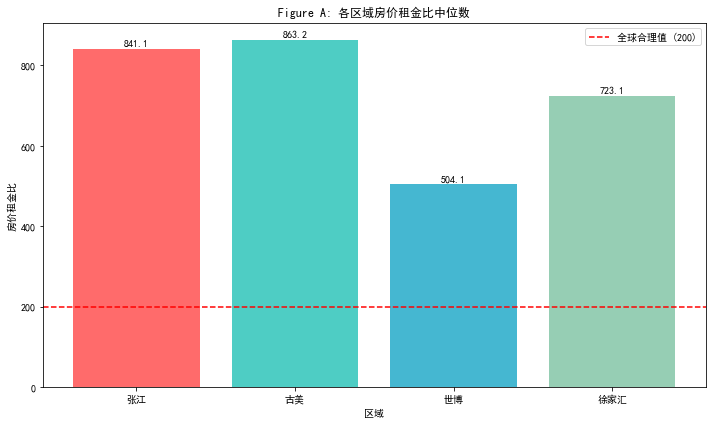

In [35]:
# 计算各区域房价租金比
price_to_rent_ratios = {}

for region in regions:
    sale_median = sale_data[region]['price_per_m2'].median() if 'price_per_m2' in sale_data[region].columns else np.nan
    rent_median = rent_data[region]['rent_per_m2'].median() if 'rent_per_m2' in rent_data[region].columns else np.nan
    
    if not pd.isna(sale_median) and not pd.isna(rent_median) and rent_median != 0:
        ratio = sale_median / rent_median
        price_to_rent_ratios[region] = ratio
        print(f"{region}: 房价{sale_median:.0f}元/㎡, 租金{rent_median:.0f}元/㎡, 比值{ratio:.1f}")

# Figure A
plt.figure(figsize=(10, 6))
regions_list = list(price_to_rent_ratios.keys())
ratios_list = list(price_to_rent_ratios.values())

bars = plt.bar(regions_list, ratios_list, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.axhline(y=200, color='red', linestyle='--', label='全球合理值 (200)')
plt.xlabel('区域')
plt.ylabel('房价租金比')
plt.title('Figure A: 各区域房价租金比中位数')
plt.legend()

for bar, value in zip(bars, ratios_list):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [36]:
# Homework3-4: 基础线性模型
print("\n" + "="*50)
print("Homework3-4: 基础线性模型")
print("="*50)

# 准备建模数据
combined_data = pd.concat([all_sale, all_rent])
location_dummies = pd.get_dummies(combined_data['区域'], prefix='location')
model_data = pd.concat([combined_data, location_dummies], axis=1)

# Model 1: 房价预测
sale_train = model_data[(model_data['数据类型'] == 'sale') & 
                       (model_data['price_per_m2'].notna()) & 
                       (model_data['面积(㎡)'].notna())]

X_sale = sale_train[['面积(㎡)'] + list(location_dummies.columns)]
y_sale = sale_train['price_per_m2']

model1 = LinearRegression()
model1.fit(X_sale, y_sale)
y_sale_pred = model1.predict(X_sale)
r2_sale = r2_score(y_sale, y_sale_pred)

# Model 2: 租金预测
rent_train = model_data[(model_data['数据类型'] == 'rent') & 
                       (model_data['rent_per_m2'].notna()) & 
                       (model_data['面积(㎡)'].notna())]

X_rent = rent_train[['面积(㎡)'] + list(location_dummies.columns)]
y_rent = rent_train['rent_per_m2']

model2 = LinearRegression()
model2.fit(X_rent, y_rent)
y_rent_pred = model2.predict(X_rent)
r2_rent = r2_score(y_rent, y_rent_pred)

print(f"Model 1 (房价) R²: {r2_sale:.3f}")
print(f"Model 2 (租金) R²: {r2_rent:.3f}")


Homework3-4: 基础线性模型
Model 1 (房价) R²: 0.307
Model 2 (租金) R²: 0.305


张江预测房价租金比: 826.0
古美预测房价租金比: 790.9
世博预测房价租金比: 522.7
徐家汇预测房价租金比: 715.2


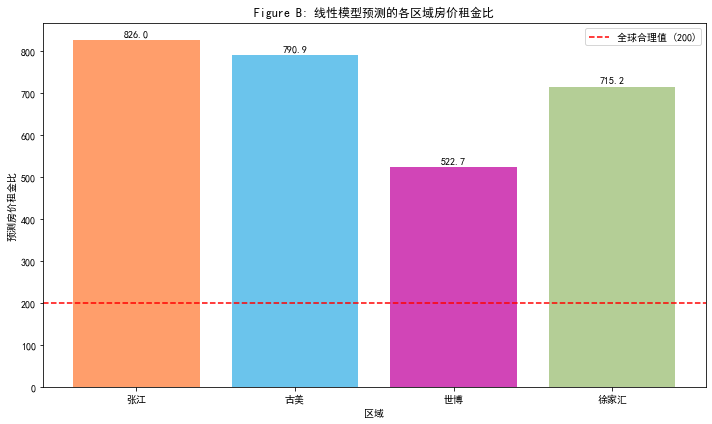

In [38]:
# 预测所有数据并计算比值
X_all = model_data[['面积(㎡)'] + list(location_dummies.columns)].fillna(model_data['面积(㎡)'].median())
model_data['pred_price'] = model1.predict(X_all)
model_data['pred_rent'] = model2.predict(X_all)
model_data['pred_ratio'] = model_data['pred_price'] / model_data['pred_rent']

# 计算各区域预测比值
predicted_ratios = {}
for region in regions:
    region_ratio = model_data[model_data['区域'] == region]['pred_ratio'].median()
    predicted_ratios[region] = region_ratio
    print(f"{region}预测房价租金比: {region_ratio:.1f}")

# Figure B
plt.figure(figsize=(10, 6))
regions_list = list(predicted_ratios.keys())
ratios_list = list(predicted_ratios.values())

bars = plt.bar(regions_list, ratios_list, color=['#FF9E6B', '#6BC4EC', '#D145B7', '#B4CE96'])
plt.axhline(y=200, color='red', linestyle='--', label='全球合理值 (200)')
plt.xlabel('区域')
plt.ylabel('预测房价租金比')
plt.title('Figure B: 线性模型预测的各区域房价租金比')
plt.legend()

for bar, value in zip(bars, ratios_list):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [39]:
# Homework3-5: 高级模型
print("\n" + "="*50)
print("Homework3-5: 高级模型分析")
print("="*50)

# 添加非线性特征
poly = PolynomialFeatures(degree=2, include_bias=False)

# Model 1+: 房价增强模型
X_sale_poly = poly.fit_transform(X_sale)
model1_plus = LinearRegression()
model1_plus.fit(X_sale_poly, y_sale)
y_sale_pred_plus = model1_plus.predict(X_sale_poly)
r2_sale_plus = r2_score(y_sale, y_sale_pred_plus)

# Model 2+: 租金增强模型
X_rent_poly = poly.fit_transform(X_rent)
model2_plus = LinearRegression()
model2_plus.fit(X_rent_poly, y_rent)
y_rent_pred_plus = model2_plus.predict(X_rent_poly)
r2_rent_plus = r2_score(y_rent, y_rent_pred_plus)

print("模型比较:")
print(f"Model 1 R²: {r2_sale:.3f} vs Model 1+ R²: {r2_sale_plus:.3f}")
print(f"Model 2 R²: {r2_rent:.3f} vs Model 2+ R²: {r2_rent_plus:.3f}")


Homework3-5: 高级模型分析
模型比较:
Model 1 R²: 0.307 vs Model 1+ R²: 0.331
Model 2 R²: 0.305 vs Model 2+ R²: 0.337


张江增强模型预测房价租金比: 808.2
古美增强模型预测房价租金比: 767.7
世博增强模型预测房价租金比: 492.3
徐家汇增强模型预测房价租金比: 725.2


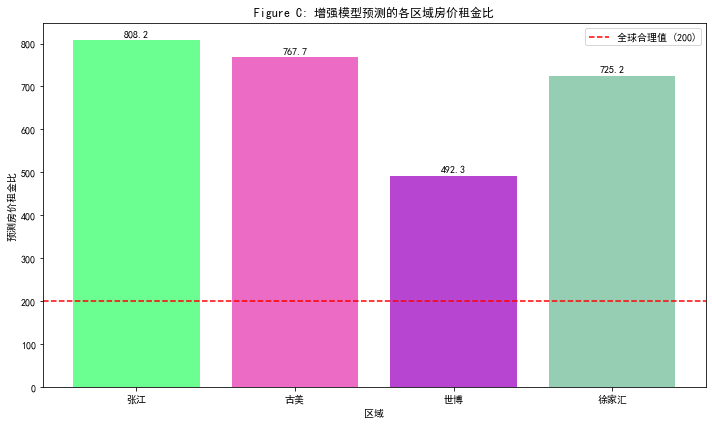

In [40]:
# 使用增强模型预测
X_all_poly = poly.transform(X_all)
model_data['pred_price_plus'] = model1_plus.predict(X_all_poly)
model_data['pred_rent_plus'] = model2_plus.predict(X_all_poly)
model_data['pred_ratio_plus'] = model_data['pred_price_plus'] / model_data['pred_rent_plus']

# 计算各区域预测比值
predicted_ratios_plus = {}
for region in regions:
    region_ratio = model_data[model_data['区域'] == region]['pred_ratio_plus'].median()
    predicted_ratios_plus[region] = region_ratio
    print(f"{region}增强模型预测房价租金比: {region_ratio:.1f}")

# Figure C
plt.figure(figsize=(10, 6))
regions_list = list(predicted_ratios_plus.keys())
ratios_list = list(predicted_ratios_plus.values())

bars = plt.bar(regions_list, ratios_list, color=['#6BFF91', '#EC6BC4', '#B745D1', '#96CEB4'])
plt.axhline(y=200, color='red', linestyle='--', label='全球合理值 (200)')
plt.xlabel('区域')
plt.ylabel('预测房价租金比')
plt.title('Figure C: 增强模型预测的各区域房价租金比')
plt.legend()

for bar, value in zip(bars, ratios_list):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
# 结果比较
print("\n" + "="*50)
print("三种方法结果比较")
print("="*50)

comparison = pd.DataFrame({
    '原始数据中位数': price_to_rent_ratios,
    '线性模型预测': predicted_ratios,
    '增强模型预测': predicted_ratios_plus
})

print(comparison)

# 样本量分析
total_samples = len(all_sale) + len(all_rent)
print(f"\n总样本量: {total_samples}")


三种方法结果比较
        原始数据中位数      线性模型预测      增强模型预测
张江   841.099549  826.011247  808.206428
古美   863.191671  790.914974  767.726973
世博   504.096001  522.711037  492.333943
徐家汇  723.122143  715.169820  725.155828

总样本量: 9459
